In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
df_train = pd.read_csv('ee-train.csv')
df_test = pd.read_csv('ee-test.csv')

In [3]:
X_train = np.array(df_train.iloc[:, :-1])
y_train = np.array(df_train.iloc[:, -1])
X_test = np.array(df_test.iloc[:, :-1])
y_test = np.array(df_test.iloc[:, -1])

scaler = StandardScaler() # Standardise input variables

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
X_train.shape

(384, 8)

In [5]:
y_train.shape

(384,)

In [26]:
y_train[:10]

array([12.74, 29.68, 36.57, 38.57, 34.72, 16.99, 15.19, 28.56, 14.51,
       25.27])

In [27]:
y_test[:10]

array([15.55, 15.55, 20.71, 19.68, 19.34, 17.05, 15.98, 29.63, 24.77,
       23.93])

# Task 2a

### ORIGINAL

In [6]:
def compute_posterior(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    # posterior mean Mu and cov SIGMA with basis matrix PHI
    # and width hyperparam alph and s2
    # where alph = lam/s2

    SIGMA = np.linalg.inv(alph*np.eye(PHI.shape[0]) + (1/s2)*PHI.T@PHI)
    Mu = (1/s2)*SIGMA@PHI.T@y
    
    return Mu, SIGMA

In [7]:
def compute_log_marginal(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    Mu, SIGMA = compute_posterior(PHI, y, alph, s2)
    N = PHI.shape[0]
    M = PHI.shape[1]
#     lgp = stats.multivariate_normal.logpdf()
    E_m_N = 1/(s2*2) * np.linalg.norm(y-PHI@Mu)**2 + alph/2*Mu.T@Mu
    lgp = 0.5*M*np.log(alph) + 0.5*N*np.log(1/s2) - E_m_N - 0.5*np.log(np.linalg.det(np.linalg.inv(SIGMA))) - 0.5*N*np.log(2*np.pi)
    return lgp



### MODIFIED

In [8]:
# def compute_posterior(X, y, sigma_w_2, sigma_n_2):
#     SIGMA = np.linalg.inv((1/sigma_w_2)*np.eye(X.shape[1]) + (1/sigma_n_2)*X.T@X)
#     Mu = (1/sigma_n_2)*SIGMA@X.T@y
    
# #     N = X.shape[0]
# #     shared = np.linalg.inv(X.T@X + sigma_n_2*sigma_w_2*np.eye(N))
# #     Mu = shared@X.T@y
# #     SIGMA = sigma_n_2*shared
#     return Mu, SIGMA

# def compute_log_marginal(X, y, sigma_w_2, sigma_n_2):

#     Mu, SIGMA = compute_posterior(X, y, sigma_w_2, sigma_n_2)
#     N = X.shape[0]
#     M = X.shape[1]
# #     lgp = stats.multivariate_normal.logpdf()
#     E_m_N = 1/(sigma_n_2*2) * np.linalg.norm(y-X@Mu)**2 + (1/sigma_w_2)/2*Mu.T@Mu
#     lgp = 0.5*M*np.log((1/sigma_w_2)) + 0.5*N*np.log(1/sigma_n_2) - E_m_N - 0.5*np.log(np.linalg.det(np.linalg.inv(SIGMA))) - 0.5*N*np.log(2*np.pi)
#     return lgp

### NEW VERSION

In [9]:
### USING ZERO-MEAN GAUSSIAN CONCEPT

def compute_log_marginal(X, y, sigma_n_2, sigma_w_2): # p(y|sigma_n_2, sigma_w_2)
    N = X.shape[0]
    cov = sigma_n_2*np.eye(N) + sigma_w_2*X@X.T
    return stats.multivariate_normal.logpdf(y, mean=None, cov=cov, allow_singular=True)
    
compute_log_marginal(X_train, y_train, 0.01, 0.01)

-10266828.784337511

### Hyperparameter grid

In [22]:
sigma_n_2_power_grid = np.linspace(-10, 10, 100)
sigma_w_2_power_grid = np.linspace(-10, 10, 100)

log_prob_list = []

for power_sigma_n_2 in sigma_n_2_power_grid:
    for power_sigma_w_2 in sigma_w_2_power_grid:
        log_prob = compute_log_marginal(X_train, y_train, 10**power_sigma_n_2, 10**power_sigma_w_2)
        log_prob_list.append(log_prob)

In [23]:
# prob_list to 2d shape
log_prob_list = np.array(log_prob_list).reshape(100, 100)

In [32]:
np.argmax(log_prob_list)

2356

In [24]:
i_max = np.unravel_index(np.argmax(log_prob_list), log_prob_list.shape)
print(i_max)

(23, 56)


In [25]:
power_sigma_n_2_opt = sigma_n_2_power_grid[i_max[0]]
power_sigma_w_2_opt = sigma_w_2_power_grid[i_max[1]]

In [26]:
print("Optimal: \npower_sigma_n_2 = {} \npower_sigma_w_2 = {} \nsigma_n_2 = {} \nsigma_w_2 = {} \nlog_prob = {}"\
      .format(power_sigma_n_2_opt, power_sigma_w_2_opt,\
              10**power_sigma_n_2_opt, 10**power_sigma_w_2_opt,\
              log_prob_list[i_max]))

Optimal: 
power_sigma_n_2 = -5.353535353535354 
power_sigma_w_2 = 1.3131313131313131 
sigma_n_2 = 4.430621457583877e-06 
sigma_w_2 = 20.565123083486515 
log_prob = -37.95516967686765


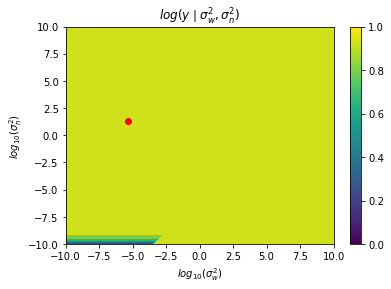

In [44]:
plt.contourf(sigma_n_2_power_grid, sigma_w_2_power_grid, log_prob_list) #[X, Y], Z
plt.scatter(power_sigma_n_2_opt, power_sigma_w_2_opt, color='red')
plt.title(r"$log (y \mid \sigma_w^2, \sigma_n^2)$")
plt.xlabel(r"$log_{10} (\sigma_w^2)$")
plt.ylabel(r"$log_{10} (\sigma_n^2)$")
plt.colorbar()
plt.show()

# plt.contourf(alph_power_grid, r_power_grid, prob_y) #[X, Y], Z
# plt.title("prob_y")
# plt.xlabel(r"$log_{10} (\alpha)$")
# plt.ylabel(r"$log_{10} (r)$")
# plt.colorbar()
# plt.show()

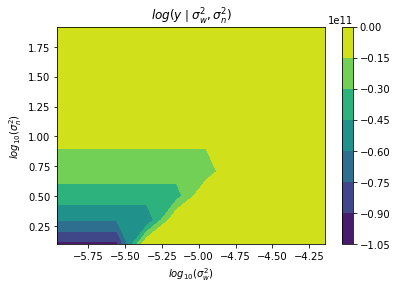

In [31]:

plt.contourf(sigma_n_2_power_grid[20:30], sigma_w_2_power_grid[50:60], log_prob_list[20:30, 50:60]) #[X, Y], Z
plt.title(r"$log (y \mid \sigma_w^2, \sigma_n^2)$")
plt.xlabel(r"$log_{10} (\sigma_w^2)$")
plt.ylabel(r"$log_{10} (\sigma_n^2)$")
plt.colorbar()
plt.show()

In [33]:
np.max(log_prob_list[20:30, 50:60])

-37.95516967686765

In [10]:
sigma_n_2_power_grid_mag = np.linspace(-6, -4, 100)
sigma_w_2_power_grid_mag = np.linspace(1, 2, 100)

log_prob_list_mag = []

for power_sigma_n_2 in sigma_n_2_power_grid_mag:
    for power_sigma_w_2 in sigma_w_2_power_grid_mag:
        log_prob = compute_log_marginal(X_train, y_train, 10**power_sigma_n_2, 10**power_sigma_w_2)
        log_prob_list_mag.append(log_prob)

In [11]:
# prob_list to 2d shape
log_prob_list_mag = np.array(log_prob_list_mag).reshape(100, 100)

In [12]:
i_max_mag = np.unravel_index(np.argmax(log_prob_list_mag), log_prob_list_mag.shape)
print(i_max_mag)

(40, 32)


In [13]:
log_prob_list_mag[i_max_mag]

-37.95497240664166

In [14]:
power_sigma_n_2_opt_mag = sigma_n_2_power_grid_mag[i_max_mag[0]]
power_sigma_w_2_opt_mag = sigma_w_2_power_grid_mag[i_max_mag[1]]

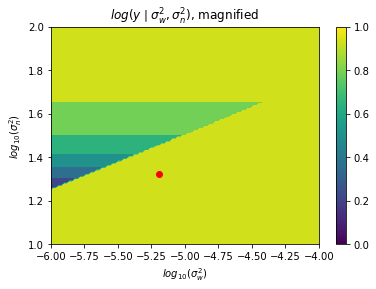

In [15]:
plt.contourf(sigma_n_2_power_grid_mag, sigma_w_2_power_grid_mag, log_prob_list_mag) #[X, Y], Z
plt.scatter(power_sigma_n_2_opt_mag, power_sigma_w_2_opt_mag, c='red')
plt.title(r"$log (y \mid \sigma_w^2, \sigma_n^2)$, magnified")
plt.xlabel(r"$log_{10} (\sigma_w^2)$")
plt.ylabel(r"$log_{10} (\sigma_n^2)$")
plt.colorbar()
plt.show()

In [16]:
sigma_n_2_opt = 10**power_sigma_n_2_opt_mag
sigma_w_2_opt = 10**power_sigma_w_2_opt_mag

print("Optimal: \nsigma_n_2_opt = {} \nsigma_w_2_opt = {}".format(sigma_n_2_opt, sigma_w_2_opt))

Optimal: 
sigma_n_2_opt = 6.4280731172843194e-06 
sigma_w_2_opt = 21.049041445120206


### Predictions and RMSE

In [17]:
def get_w(X, y, sigma_n_2, sigma_w_2):
    return np.linalg.inv(X.T@X + sigma_n_2*(1/sigma_w_2)*np.eye(X.shape[1]))@X.T@y

In [18]:
w = get_w(X_train, y_train, sigma_n_2_opt, sigma_w_2_opt)
w

array([-7.23462721, -3.9421508 ,  0.75595012, -4.23191504,  7.2039515 ,
       -0.12516927,  2.77021895,  0.20406264])

In [40]:
y_intercept = y_train.mean()

In [41]:
y_test_pred = X_test@w + y_intercept

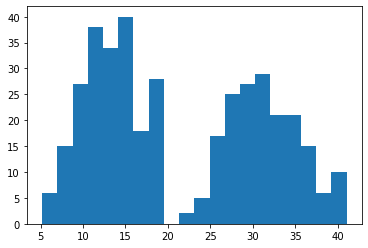

In [42]:
plt.hist(y_test_pred, bins=20)
plt.show()

In [43]:
y_test_pred[:10]

array([22.5217685 , 22.40759051, 24.93505144, 24.82087345, 23.80438556,
       26.09460411, 25.75207015, 27.24825326, 32.05114282, 31.93696483])

In [44]:
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print("test RMSE =", rmse_test)

test RMSE = 2.8435880487131406


In [45]:
def error_histogram(y_pred, y_targ):
    error_list = y_pred.reshape(-1, 1) - y_targ.reshape(-1, 1)
    plt.hist(error_list, bins=20)
    plt.xlabel("Error")
    plt.ylabel("Number of samples in the bin")
    plt.show()

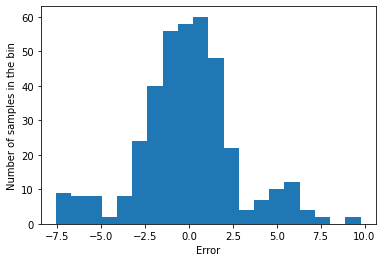

In [46]:
error_histogram(y_test_pred, y_test)

# Task 2b